## Trabajo de Fin de Grado - Grado en Ingeniería Informática

# Tecnología Deep Learning Aplicada a Señales Respiratorias para la ayuda al Diagnóstico de la Apnea del Sueño

### Marta Fernández Poyatos


#### CNN 2 dimensiones


In [1]:
import numpy as np 
import pandas as pd
import os
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

In [2]:
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [5]:
device

device(type='cuda')

In [6]:
!nvidia-smi

Fri May 27 20:57:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.13       Driver Version: 496.13       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 59%   47C    P5    55W / 370W |  12222MiB / 12288MiB |     57%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
hiperparametros = {
    'epocas' : 200,
    'lr' : 0.001,
    'batch_size' : 32,
    'seed' : 56389856,
    'dropout' : 0.2
}

### Creación de la clase Dataset para cargar los datos de test

In [8]:
class MyDatasetTest(Dataset):
    def __init__(self, x_a, x_th, y) -> None:
        self.x_a = x_a
        self.x_th = x_th
        self.y = y
        
    def __getitem__(self, index):
        x_ind_a = self.x_a[index]
        x_ind_th = self.x_th[index]
        y_ind = self.y[index]
        
        X = torch.empty((2, x_ind_a.shape[0]))
        X[0,:] = torch.from_numpy(x_ind_a).float()
        X[1,:] = torch.from_numpy(x_ind_th).float()
                  
        y = torch.Tensor([y_ind]).float()
        
        return X.reshape(1, X.shape[0], X.shape[1]),y

    def __len__(self):
        return len(self.x_a)

### Modelo a testear

In [9]:
class MyModel(nn.Module): 
    def __init__(self):

        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 4, kernel_size = (1, 32), stride= (1,2)) ,
            nn.BatchNorm2d(num_features = 4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (1,2), stride = (1,1)),
            nn.Dropout(p = hiperparametros['dropout'])
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 4, out_channels = 8, kernel_size = (1, 32), stride= (1,2)) ,
            nn.BatchNorm2d(num_features = 8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (1,2), stride = (1,1)),
            nn.Dropout(p = hiperparametros['dropout'])
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (1,32), stride= (1,2)) ,
            nn.BatchNorm2d(num_features = 16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (1,2), stride = (1,1)),
            nn.Dropout(p = hiperparametros['dropout'])
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (1, 32), stride= (1,2)) ,
            nn.BatchNorm2d(num_features = 32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (1,2), stride = (1,1)),
            nn.Dropout(p = hiperparametros['dropout'])
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (1, 32), stride= (1,2)) ,
            nn.BatchNorm2d(num_features = 64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (1,2), stride = (1,1)),
            nn.Dropout(p = hiperparametros['dropout'])
        )

        self.layer6 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (1, 32), stride= (1,2)) ,
            nn.BatchNorm2d(num_features = 128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (1,2), stride = (1,1)),
            nn.Dropout(p = hiperparametros['dropout'])
        )

        self.lin = nn.Linear(in_features = 128* 2* 156, out_features = 1)
    

    def forward(self,x): 
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)

        out = out.reshape(out.shape[0], out.shape[1]*out.shape[2]*out.shape[3])
        out = self.lin(out)


        return out 

### Carga del mejor modelo en validación

In [10]:
model = MyModel().to(device)
model.load_state_dict(torch.load('C:/Users/GIB/Documents/Marta/trained_models/da_kappa2d_all/pruebaCentral_da_kappa2d_all_02drop128canales32kernel6capas.pth'))

<All keys matched successfully>

### Definición de la función de pérdida

In [11]:
criterion = torch.nn.HuberLoss(reduction= "mean")

### Ruta a los datos de test

In [12]:
basepath = "C:/Users/GIB/Documents/Marta/test/"
files = os.listdir(basepath)

### Cálculo del AHI para un individuo

In [13]:
def get_AHI_pred_real(outputs, labels):
    AHI_pred = sum(outputs)/len(outputs)*3
    AHI_real = sum(labels)/len(labels)*3
    
    return AHI_pred, AHI_real

### Creación de un DataFrame con AHI real y predicho y pérdida de cada individuo

In [14]:
df = pd.DataFrame(columns = ['Name', 'AHI_pred', 'AHI_real', 'loss_test'])

### Bucle que recorre cada individuo:

1. Carga datos
2. Creacion de dataset por cada individuo
3. Creación de dataloader
4. Evaluación de los datos del individuo de test sobre el modelo
5. Cálculo del AHI real y predicho por cada individuo
6. Almacenamiento de la información de cada individuo en el DataFrame creado previamente

In [15]:
for i in range(len(files)):
    filename = files[i]
    mat = sio.loadmat(basepath+filename)
    
    abdores = mat.get('stand_matrix_abdores')
    thorres = mat.get('stand_matrix_thorres')
    y_events_data = mat.get('vec_all_central')
    
    thorres_t = thorres.transpose()
    abdores_t = abdores.transpose()

    y_events_r = np.reshape(y_events_data, (y_events_data.shape[1],))
    
    dataset = MyDatasetTest(thorres_t, abdores_t, y_events_r)
    
    dataloader = DataLoader(dataset, batch_size= 64, shuffle= True)
    
    model.eval()
    
    with torch.no_grad():
            for data in dataloader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)

                loss_val = criterion(outputs, labels)
                loss_medio_test = loss_val.item()
                AHI_pred_test, AHI_real_test = get_AHI_pred_real(outputs, labels)
                

   
    new_row = pd.DataFrame([[filename, AHI_pred_test.item(), AHI_real_test.item(), loss_medio_test]], 
                           columns = ['Name', 'AHI_pred', 'AHI_real', 'loss_test'])
    
    
    df = pd.concat([df, new_row])
    

In [16]:
df

,Name,AHI_pred,AHI_real,loss_test
0,filt_shhs1-200078.mat,0.275037,0.391304,0.047221
0,filt_shhs1-200079.mat,0.120416,0.130435,0.011806
0,filt_shhs1-200081.mat,0.212174,0.115385,0.010832
0,filt_shhs1-200086.mat,0.05962,0.0,0.000198
0,filt_shhs1-200088.mat,1.012333,0.272727,0.142803
...,...,...,...,...
0,filt_shhs2-205785.mat,0.087167,0.206897,0.030942
0,filt_shhs2-205786.mat,0.713387,4.354838,1.176839
0,filt_shhs2-205796.mat,0.160624,0.107143,0.028809
0,filt_shhs2-205798.mat,0.384889,0.636364,0.084429


### Discretización del AHI

In [17]:
AHI_pred_disc = np.digitize(df.AHI_pred, bins = np.array([5,15,30]))
AHI_real_disc = np.digitize(df.AHI_real, bins = np.array([5,15,30]))

### Cálculo del índice kappa y el accuracy

In [18]:
kappa = cohen_kappa_score(AHI_pred_disc, AHI_real_disc)
accuracy = sum(AHI_pred_disc == AHI_real_disc).item()/len(AHI_real_disc)   

In [19]:
sum(AHI_real_disc == 0), sum(AHI_real_disc == 1), sum(AHI_real_disc == 2), sum(AHI_real_disc == 3)

(4904, 74, 22, 0)

In [20]:
kappa

0.5356566792120827

In [21]:
accuracy

0.9848

### Cálculo de sensibilidad y especifidad

In [22]:
def sens_especif_mat_conf_por_clases_inferiores(AHI_real_disc_, AHI_pred_disc_, clase):
    FP = sum(AHI_pred_disc_[AHI_real_disc_ > clase] <= clase)
    TP = sum(AHI_pred_disc_[AHI_real_disc_ <= clase] <= clase)
    TN = sum(AHI_pred_disc_[AHI_real_disc_ > clase] > clase)
    FN = sum(AHI_pred_disc_[AHI_real_disc_ <= clase] > clase)
    sensibilidad = TP/(TP + FN)
    especifidad = TN/(TN + FP)
    VPP = TP/(TP + FP)
    VPN = TN/(TN + FN)
    
    AHI_real_disc_clase = np.copy(AHI_real_disc_)
    AHI_real_disc_clase[AHI_real_disc_clase > clase] = 100
    AHI_real_disc_clase[AHI_real_disc_clase <= clase] = 0

    AHI_pred_disc_clase = np.copy(AHI_pred_disc_)
    AHI_pred_disc_clase[AHI_pred_disc_clase > clase] = 100
    AHI_pred_disc_clase[AHI_pred_disc_clase <= clase] = 0
    
    best_cfmatrix_val_clase = confusion_matrix(AHI_real_disc_clase, AHI_pred_disc_clase)
    
    group_counts = ["{0:0.0f}".format(value) for value in
                best_cfmatrix_val_clase.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         best_cfmatrix_val_clase.flatten()/np.sum(best_cfmatrix_val_clase)]

    labels = [f"{v1}\n{v2}\n" for v1, v2 in
              zip(group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    plt.rcdefaults()
    sns.set(font_scale=1.4)
    sns.set(rc = {'figure.figsize':(5,4)})

    sns.heatmap(best_cfmatrix_val_clase, annot=labels, annot_kws={"size": 14}, fmt='',  cmap='Blues')

    plt.title("\n Matriz de confusión")
    plt.xlabel("Estimado \n \n \n")
    plt.ylabel("\n \n Real")
    plt.show()
    plt.clf()
    plt.close()

    return sensibilidad, especifidad, VPP, VPN

In [23]:
def sens_especif_mat_conf_por_clases(AHI_real_disc_, AHI_pred_disc_, clase):
    FP = sum(AHI_pred_disc_[AHI_real_disc_ == clase] == clase)
    TP = sum(AHI_pred_disc_[AHI_real_disc_ <= clase] == clase)
    TN = sum(AHI_pred_disc_[AHI_real_disc_ == clase] != clase)
    FN = sum(AHI_pred_disc_[AHI_real_disc_ <= clase] != clase)
    sensibilidad = TP/(TP + FN)
    especifidad = TN/(TN + FP)
    VPP = TP/(TP + FP)
    VPN = TN/(TN + FN)
    
    AHI_real_disc_clase = np.copy(AHI_real_disc_)
    AHI_real_disc_clase[AHI_real_disc_clase != clase] = 100

    AHI_pred_disc_clase = np.copy(AHI_pred_disc_)
    AHI_pred_disc_clase[AHI_pred_disc_clase != clase] = 100
    
    best_cfmatrix_val_clase = confusion_matrix(AHI_real_disc_clase, AHI_pred_disc_clase)
    
    group_counts = ["{0:0.0f}".format(value) for value in
                best_cfmatrix_val_clase.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         best_cfmatrix_val_clase.flatten()/np.sum(best_cfmatrix_val_clase)]

    labels = [f"{v1}\n{v2}\n" for v1, v2 in
              zip(group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    plt.rcdefaults()
    sns.set(font_scale=1.4)
    sns.set(rc = {'figure.figsize':(5,4)})

    sns.heatmap(best_cfmatrix_val_clase, annot=labels, annot_kws={"size": 14}, fmt='',  cmap='Blues')

    plt.title("\n Matriz de confusión")
    plt.xlabel("Estimado \n \n \n")
    plt.ylabel("\n \n Real")
    plt.show()
    plt.clf()
    plt.close()

    return sensibilidad, especifidad, VPP, VPN

## Cálculo de la sensibilidad, especifidad, VPP y VPN por clases

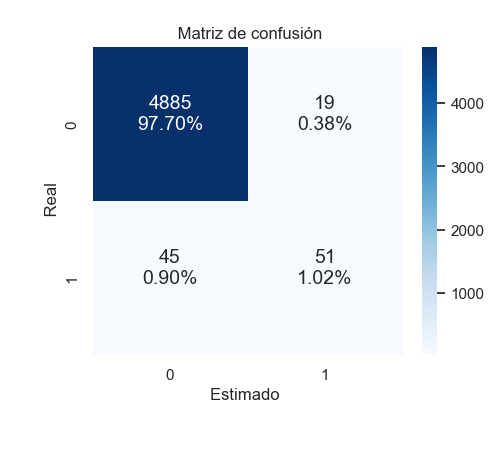

Sensibilidad =  0.9961256117455138
Especifidad =  0.003874388254486134
VPP =  0.5
VPN =  0.5


In [24]:
sensibilidad_0, especifidad_0, VPP_0, VPN_0 = sens_especif_mat_conf_por_clases(AHI_real_disc, AHI_pred_disc, 0)
print("Sensibilidad = ", sensibilidad_0)
print("Especifidad = ", especifidad_0)
print("VPP = ", VPP_0)
print("VPN = ", VPN_0)

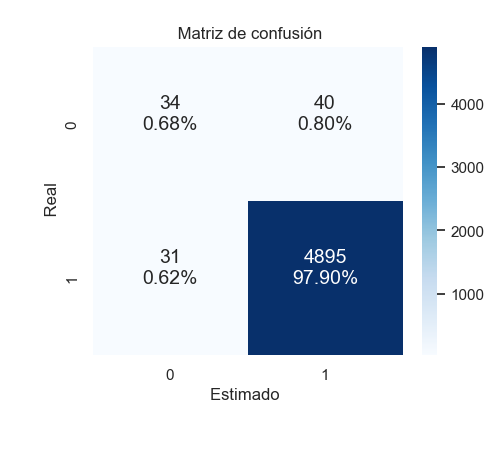

Sensibilidad =  0.01064684612294094
Especifidad =  0.5405405405405406
VPP =  0.6091954022988506
VPN =  0.008056394763343404


In [25]:
sensibilidad_1, especifidad_1, VPP_1, VPN_1 = sens_especif_mat_conf_por_clases(AHI_real_disc, AHI_pred_disc, 1)
print("Sensibilidad = ", sensibilidad_1)
print("Especifidad = ", especifidad_1)
print("VPP = ", VPP_1)
print("VPN = ", VPN_1)

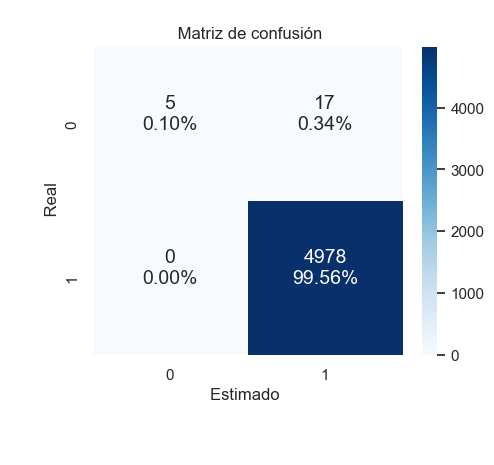

Sensibilidad =  0.001
Especifidad =  0.7727272727272727
VPP =  0.5
VPN =  0.003391859537110934


In [26]:
sensibilidad_2, especifidad_2, VPP_2, VPN_2 = sens_especif_mat_conf_por_clases(AHI_real_disc, AHI_pred_disc, 2)
print("Sensibilidad = ", sensibilidad_2)
print("Especifidad = ", especifidad_2)
print("VPP = ", VPP_2)
print("VPN = ", VPN_2)

## Cálculo de la sensibilidad y especifidad por cada clase o las clases inferiores a ella

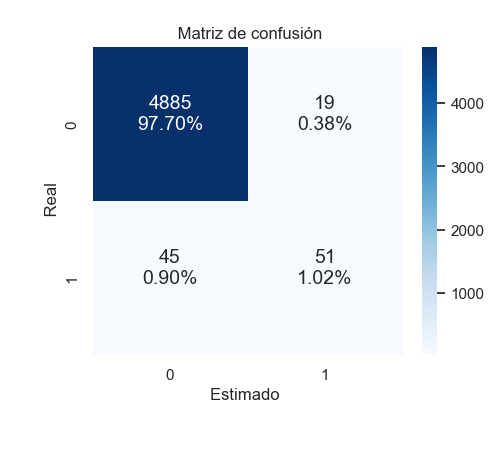

Sensibilidad =  0.9961256117455138
Especifidad =  0.53125
VPP =  0.9908722109533469
VPN =  0.7285714285714285


In [27]:
sensibilidad_0_inf, especifidad_0_inf, VPP_0_inf, VPN_0_inf = sens_especif_mat_conf_por_clases_inferiores(AHI_real_disc, AHI_pred_disc, 0)
print("Sensibilidad = ", sensibilidad_0_inf)
print("Especifidad = ", especifidad_0_inf)
print("VPP = ", VPP_0_inf)
print("VPN = ", VPN_0_inf)

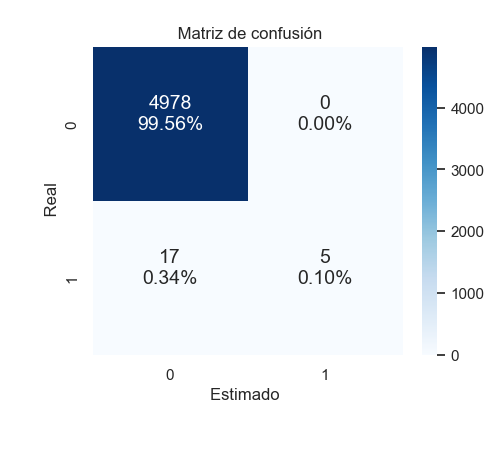

Sensibilidad =  1.0
Especifidad =  0.22727272727272727
VPP =  0.9965965965965966
VPN =  1.0


In [28]:
sensibilidad_1_inf, especifidad_1_inf, VPP_1_inf, VPN_1_inf = sens_especif_mat_conf_por_clases_inferiores(AHI_real_disc, AHI_pred_disc, 1)
print("Sensibilidad = ", sensibilidad_1_inf)
print("Especifidad = ", especifidad_1_inf)
print("VPP = ", VPP_1_inf)
print("VPN = ", VPN_1_inf)

### Diferentes representaciones de matrices de confusión

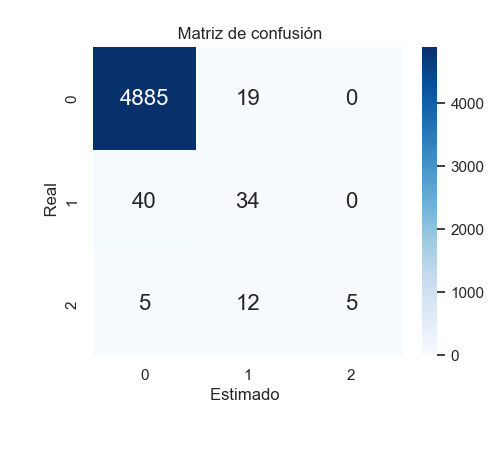

In [29]:
best_cfmatrix_val = confusion_matrix(AHI_real_disc, AHI_pred_disc)
df_cm = pd.DataFrame(best_cfmatrix_val, range(3), range(3))
plt.rcdefaults()
sns.set(font_scale=1.4)
sns.set(rc = {'figure.figsize':(5,4)})
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='', cmap = 'Blues')
plt.title("\n Matriz de confusión")
plt.xlabel("Estimado \n \n \n")
plt.ylabel("\n \n Real")
plt.show()
plt.clf()
plt.close()

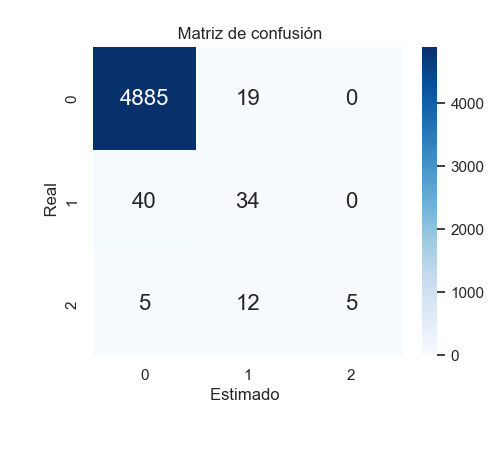

In [30]:
df_cm = pd.DataFrame(best_cfmatrix_val, range(3), range(3))
plt.rcdefaults()
sns.set(font_scale=1.4)
sns.set(rc = {'figure.figsize':(5,4)})
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='', cmap = 'Blues')
plt.title("\n Matriz de confusión")
plt.xlabel("Estimado \n \n \n")
plt.ylabel("\n \n Real")
plt.show()
plt.clf()
plt.close()

In [31]:
cf_mat_row = np.zeros((3,3))
for i in range(best_cfmatrix_val.shape[0]):
    cf_mat_row[i,:] = best_cfmatrix_val[i]/sum(best_cfmatrix_val[i])

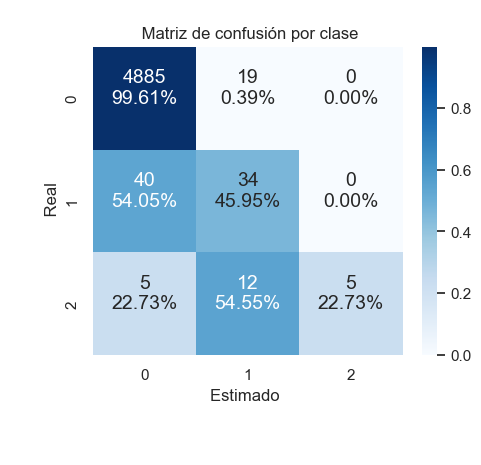

In [32]:
group_counts = ["{0:0.0f}".format(value) for value in
                best_cfmatrix_val.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_mat_row.flatten()]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(3,3)

plt.rcdefaults()
sns.set(font_scale=1.4)
sns.set(rc = {'figure.figsize':(5,4)})

sns.heatmap(cf_mat_row, annot=labels, annot_kws={"size": 14}, fmt='',  cmap='Blues')

plt.title("\n Matriz de confusión por clase")
plt.xlabel("Estimado \n \n \n")
plt.ylabel("\n \n Real")
plt.show()
plt.clf()
plt.close()

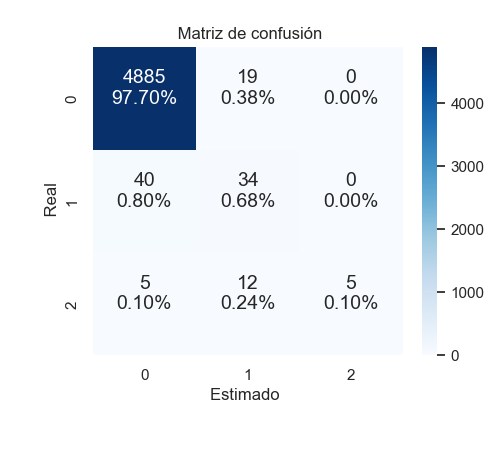

In [33]:
group_counts = ["{0:0.0f}".format(value) for value in
                best_cfmatrix_val.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     best_cfmatrix_val.flatten()/np.sum(best_cfmatrix_val)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(3,3)

plt.rcdefaults()
sns.set(font_scale=1.4)
sns.set(rc = {'figure.figsize':(5,4)})

sns.heatmap(best_cfmatrix_val, annot=labels, annot_kws={"size": 14}, fmt='',  cmap='Blues')

plt.title("\n Matriz de confusión")
plt.xlabel("Estimado \n \n \n")
plt.ylabel("\n \n Real")
plt.show()
plt.clf()
plt.close()